# $\textit{Análisis de respuestas impulsivas}$
$\textit{Filtro lineal óptimo}$

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal as sp
import helper as hp
import importlib
importlib.reload(hp)

<module 'helper' from 'c:\\Users\\Gonzalo\\Documents\\Informatica\\EclipseWorkspacePython\\PASA_TP2\\helper.py'>

In [76]:
%matplotlib widget

In [77]:
fs = 48000
t = np.linspace(0, 10, 10*fs, endpoint=False)
f0 = 20
f1 = 20000
T = 10
k = (f1/f0)**(1/T)

chirpLinearSignal = sp.chirp(t, f0=f0, t1=10, f1=f1, method='linear')
chirpExpSignal = np.sin(2 * np.pi * f0 * (k**t-1)/np.log(k))
gaussSignal = np.random.normal(0, 1, size=fs*10)
squareSignal = sp.square(2 * np.pi * 100 * t)

In [78]:
origfs, origSignal, origpath = hp.getOriginalSignals()

In [79]:
recfs, recSignal, recpath = hp.getRecordedSignals()

c:\Users\Gonzalo\Documents\Informatica\EclipseWorkspacePython\PASA_TP2\helper.py:36: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs3, recchirpLinearSignal = io.wavfile.read(path[2])
c:\Users\Gonzalo\Documents\Informatica\EclipseWorkspacePython\PASA_TP2\helper.py:37: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs4, recchirpExpSignal = io.wavfile.read(path[3])
c:\Users\Gonzalo\Documents\Informatica\EclipseWorkspacePython\PASA_TP2\helper.py:38: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs5, recgaussSignal = io.wavfile.read(path[4])
c:\Users\Gonzalo\Documents\Informatica\EclipseWorkspacePython\PASA_TP2\helper.py:39: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs6, recsquareSignal = io.wavfile.read(path[5])
c:\Users\Gonzalo\Documents\Informatica\EclipseWorkspacePython\PASA_TP2\helper.py:40: WavFileWarning: Chunk (non-data) not understood, skipping it.
  
c:\Users\Gonzalo\Documents\Informatica\EclipseWorkspaceP

In [ ]:
hmonio = sp.hilbert(recImpulse)
hfiltered = sp.convolve(np.abs(hmonio), np.ones(100))
hdb = 20*np.log10(hfiltered/hfiltered.max())
plt.figure()
plt.plot(np.linspace(0, len(hdb)/fs, len(hdb)), hdb)

In [ ]:
875e-3*48000

Comparamos los espectros de potencia

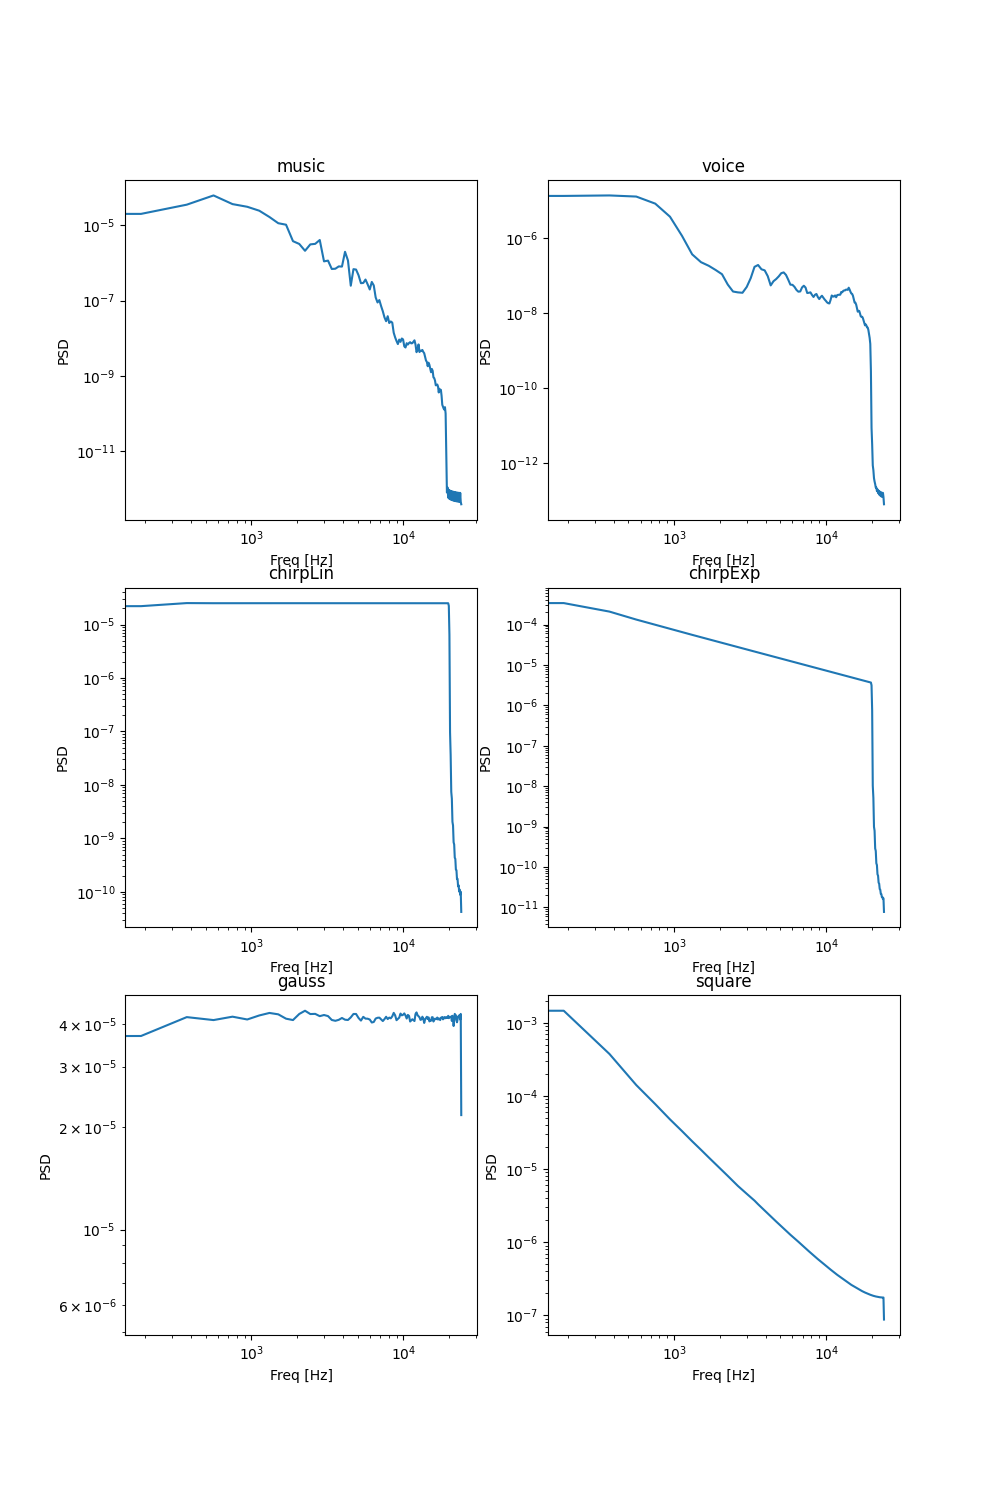

In [81]:
plt.figure(figsize=(10, 15))

for i, (name, s) in enumerate(zip(origSignal.keys(), origSignal.values())):
    f, Pxx_den = sp.welch(s, fs=fs, window='bartlett')
    plt.subplot(3, 2, i+1)
    plt.title(f"{name}")
    plt.xlabel('Freq [Hz]')
    plt.ylabel('PSD')
    plt.loglog(f, Pxx_den)

Observando los espectrogramas anteriores, intuimos que la señal que mejor va funcionar para obtener h(n) es el barrido lineal porque excita al sistema (en este caso en el living de una casa) con un espectro de potencia más constante, en términos logarítmicos que los demás. TODO: VER -> Este espectro plano permite que el resultado del filtro óptimo ajuste directamente sobre el sistema que se quiere modelar y no tambien tome las caracteristicas de la señal que se esta utilizando. El ruido gaussiano tambien tiene una caracteristica plana, pero al ser una muestra de un ensamble no tiene un espectro realmente plano.

# Modelado de sistema

$$ w_o = R^{-1}*p $$

$$ R = \begin{bmatrix}
Rxx(0) & Rxx (-1) & ... & Rxx(-(M-1)) \\
Rxx(-1) & Rxx (0) & ... & Rxx(-(M-2)) \\
... & & & \\

\end{bmatrix}
$$
$$ p = \begin{bmatrix}
Rxy(1) & Rxy (2) & ... & Rxy(M) \\

\end{bmatrix}
$$

![Alt text](image.png)

In [170]:
wo, jo, nmse = hp.get_optimal_params(origSignal['music'], origSignal['music'], 12500)

out = sp.lfilter(wo, [1.0], recSignal['music'])

print(nmse)


1.8261776119776923e-07


¿Cómo podemos reducir el cálculo necesario?



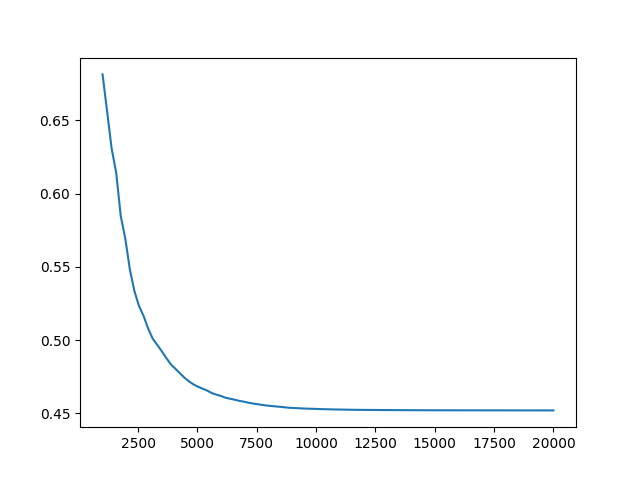

In [102]:
Ms = np.linspace(5000, 50000, 10, dtype=int)
jos = np.zeros(len(Ms))
for i, M in enumerate(Ms):
    wo, jo, nmse = hp.get_optimal_params(origSignal['chirpLin'], recSignal['chirpLin'], M)
    jos[i] = nmse

plt.figure()
plt.plot(Ms, jos)

Obtenemos las respuestas al impulso de la habitacion para cada excitacion

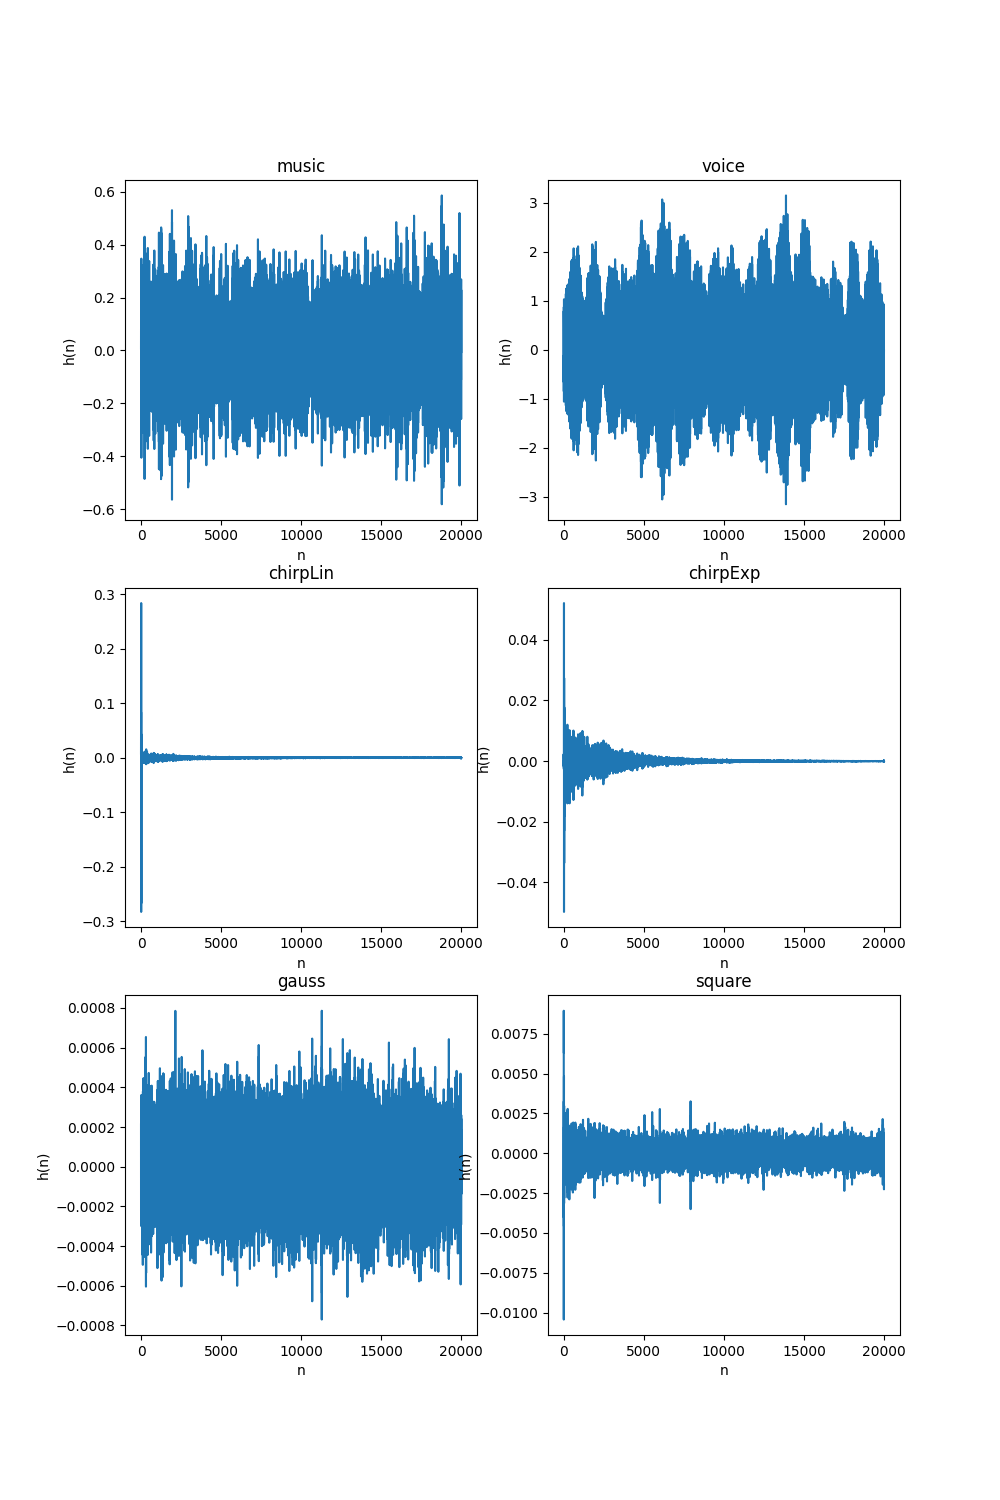

In [200]:
M = 20000 #Ordenes optimo encontrado
h_n = []
nmses = []

plt.figure(figsize=(10, 15))
for i, (name, os, rs) in enumerate(zip(origSignal.keys(), origSignal.values(), recSignal.values())):
    h, jo, nmse = hp.get_optimal_params(os, rs, M)
    plt.subplot(3, 2, i+1)
    plt.title(f"{name}")
    plt.xlabel('n')
    plt.ylabel('h(n)')
    plt.plot(h)
    h_n.append(h)
    nmses.append(h)
plt.show()

Obtenemos la respuesta en frecuencia de cada estimacion de h(n)

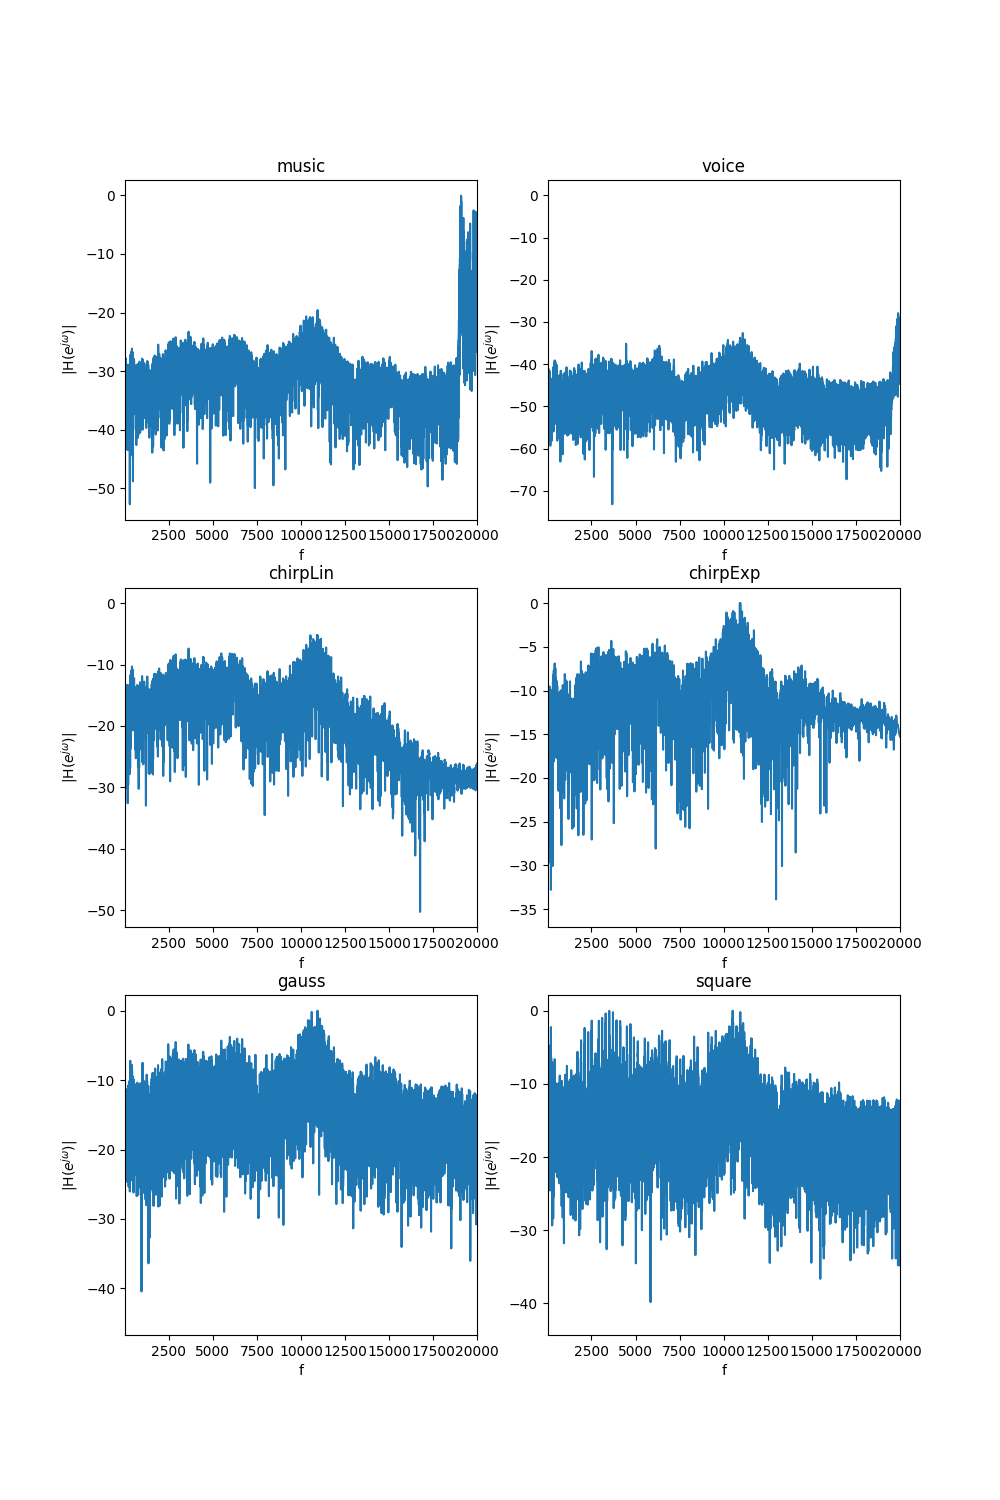

In [201]:
plt.figure(figsize=(10, 15))
for i, (name, h) in enumerate(zip(recSignal.keys(), h_n)):
    paddingLen = 2**(len(h)*2).bit_length()
    H = np.fft.rfft(h, paddingLen)
    f = np.fft.rfftfreq(paddingLen, 1/fs)

    plt.subplot(3, 2, i+1)
    plt.title(f"{name}")
    plt.xlabel('f')
    plt.ylabel('|H($e^{j\omega}$)|')
    plt.xlim([f0,f1])
    plt.plot(f, 10*np.log10(np.abs(H)/abs(H).max()))
    #plt.semilogx(f, 10*np.log10(np.abs(H)/abs(H).max()))
plt.show()

Calculamos los MSE normalizados

Esto no puede ser negativo mepa

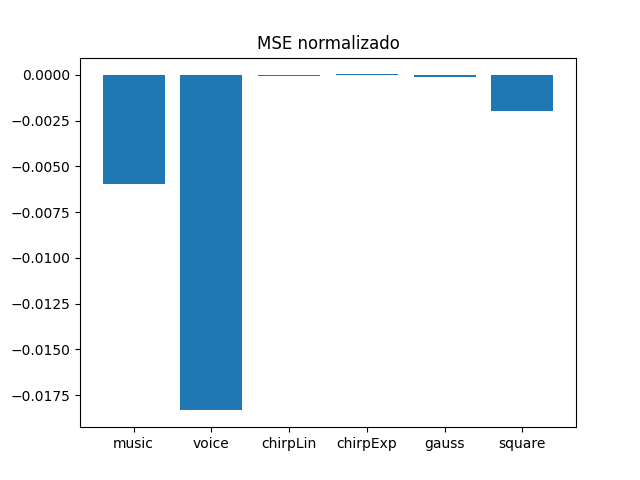

In [202]:
bars = []
for i in range(len(recSignal)):
    bars.append(nmses[i][M-1])
plt.figure()
plt.title("MSE normalizado")
plt.bar(recSignal.keys(), bars)
plt.show()

Resultado

In [238]:
result = sp.convolve(h_n[3], recSignal['music'], mode='full') / sum(recSignal['music'])

In [239]:
hp.play(recSignal["music"], recfs["music"])

In [240]:
hp.play(result, fs)